# Testing:

In this notebook we present the testing results for the trained models, both in the original `tf-keras` format and in the quantised versions.

In [72]:
import sklearn.metrics as metrics
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np
import os

TEST_DATA_DIR = "data/testData"
IMAGE_SIZE = (112, 112)

# Models paths
BASE_MODEL = "models/trained_model"
MODEL_ID = "base"

## 0. Data preparation:

We start by loading the base dataset

In [15]:
class_names = sorted( os.listdir(TEST_DATA_DIR) )

# Load the dataset
test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    image_size=IMAGE_SIZE,
    batch_size=1   
)

# This is a standard preprocessing function
preprocessing = keras.Sequential([
    keras.layers.Rescaling(scale=1./255.),
])

# Apply the preprocessing
test_ds = test_ds.map(lambda x, y: (preprocessing(x, training=False), y) )

Found 3615 files belonging to 7 classes.


## 1. Original Tensorflow

We will start by having the "max-accuracy", we expect the performance to degreda in later steps with respect to this value.

In [9]:
# Load the tf model
base_model = keras.models.load_model(BASE_MODEL)
base_model.summary()

Model: "BaseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Backbone (KerasLayer)       (None, 256)               218544    
                                                                 
 BatchNorm1 (BatchNormaliza  (None, 256)               1024      
 tion)                                                           
                                                                 
 Output (Dense)              (None, 7)                 1799      
                                                                 
Total params: 221367 (864.71 KB)
Trainable params: 215383 (841.34 KB)
Non-trainable params: 5984 (23.38 KB)
_________________________________________________________________


Get the base accuracy:

In [16]:
test_loss, test_acc = base_model.evaluate(
    test_ds
)

print("Test loss:", test_loss)
print("Test Acc:", test_acc)

3615/3615 [==============================] - 11s 3ms/step - loss: 0.1861 - categorical_accuracy: 0.9546
Test loss: 0.1861344575881958
Test Acc: 0.9546334743499756


These results are pretty much in line with the values we got at the training loop in the validation split.

## 2. TensorflowLite models:

Now we start testing the results in the quantized versions:

In [79]:
MODEL_QUANT_PATH = f"outputs/{MODEL_ID}/model_quant.tflite"
MODEL_QUANT_INT_FLOAT_PATH = f"outputs/{MODEL_ID}/model_quant_int_float.tflite"
MODEL_QUANT_FUL_INT_PATH = f"outputs/{MODEL_ID}/model_quant_full_int.tflite"


def load_model_interpreter(path):
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    return interpreter


def evaluate_model(interpreter):
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # The memory positions for the in/out
    input_index = input_details["index"]
    output_index = output_details["index"]

    # Run predictions on every image in the "test" dataset.
    predictions, labels = [], []
    for test_image, test_label in test_ds:
        # Check if the input type is quantized, then rescale input data to uint8
        if input_details["dtype"] != test_image.dtype:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point
            test_image = np.array(test_image).astype(input_details["dtype"])

        # Run inference
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.get_tensor(output_index)[0]
        predictions.append(output.argmax())
        labels.append(np.array(test_label[0]).argmax())

    # Get the accuracy and f1-score
    accuracy = metrics.accuracy_score(labels, predictions)
    f1_score = metrics.f1_score(labels, predictions, average='weighted')
    print("Acc:", accuracy)
    print("F1-Score:", f1_score)
    
    # Compare prediction results with ground truth labels to calculate accuracy.
    c_matrix = metrics.confusion_matrix(labels, predictions, normalize='true') * 100
    disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=c_matrix,
        display_labels=class_names,
    )
    disp.plot()
    plt.show()

Now test the different models:

Acc: 0.9477178423236514
F1-Score: 0.9480150610585522


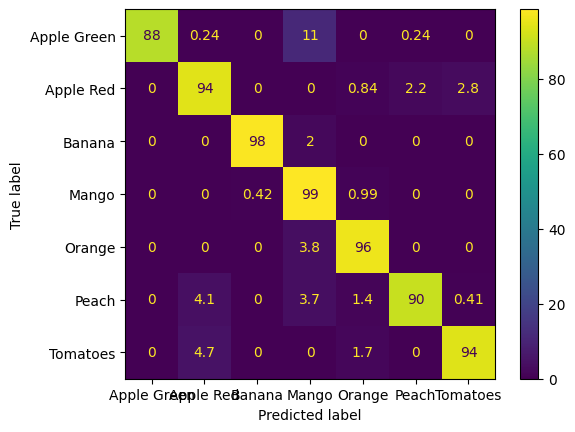

In [81]:
MODEL_QUANT_PATH = f"outputs/{MODEL_ID}/model_quant.tflite"
test_model = load_model_interpreter(MODEL_QUANT_PATH)
evaluate_model(test_model)

Acc: 0.9394190871369295
F1-Score: 0.9398950040852353


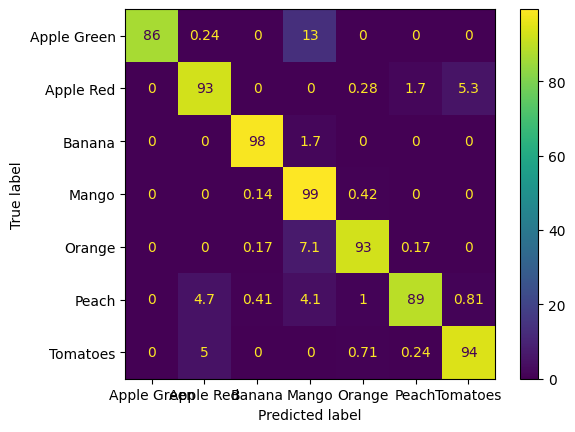

In [82]:
MODEL_QUANT_INT_FLOAT_PATH = f"outputs/{MODEL_ID}/model_quant_int_float.tflite"
test_model = load_model_interpreter(MODEL_QUANT_INT_FLOAT_PATH)
evaluate_model(test_model)

Acc: 0.9421853388658368
F1-Score: 0.9425155937167538


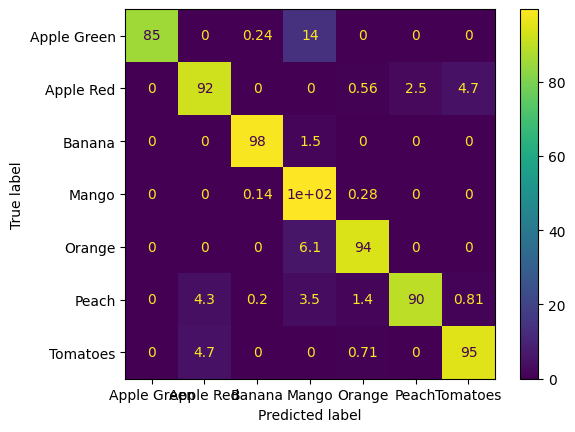

In [83]:
MODEL_QUANT_FUL_INT_PATH = f"outputs/{MODEL_ID}/model_quant_full_int.tflite"
test_model = load_model_interpreter(MODEL_QUANT_FUL_INT_PATH)
evaluate_model(test_model)